In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import re
import string
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
import nltk.corpus

In [ ]:
#Windows
vacancies = pd.read_json(r'C:\Users\nonta\Dropbox\My PC (LAPTOP-VMKUGGQ6)\Desktop\Master-DS\DSP\vacancies_large.json')

In [2]:
#Mac
vacancies = pd.read_json(r'/Users/nalevizos/Desktop/DSP/vacancies_large.json')

In [3]:
vacancies = pd.read_json(r'C:\Users\flori\Documents\Git\dsp-victory\data\vacancies_large.json') 

#### Preprocessing

In [4]:
## Lower case
vacancies["body"] = vacancies["body"].apply(lambda x: " ".join(x.lower()for x in x.split()))

#### Create RegEx list

In [9]:
def regex_list():
    flexible_orange = open(r'C:\Users\flori\Documents\Git\dsp-victory\data\flexible_orange_v2.txt')
    list_of_regex = []
    for line in flexible_orange:
        line = re.sub('\n', '', line)
        line = re.compile(line)
        list_of_regex.append(line)

    flexible_orange.close()

    return list_of_regex

In [10]:
list_of_regex = regex_list()
list_of_regex

[re.compile(r'==bijverdien==', re.UNICODE),
 re.compile(r'(?P<prestr>.*)(?P<relstr>\sbijverdienen\s+.{0,30}naast\s+((je|jouw|uw)\s+)?(school|studie))(?P<poststr>.*)',
 re.UNICODE),
 re.compile(r'==bijbaan==', re.UNICODE),
 re.compile(r'(?P<prestr>.*)(?P<relstr>\sbijbaan\s+.{0,30}((passen|aanpassen|aangepast|passend|aangepast)\s+)(aan|bij)\s+(je\s+|jouw\s+|uw\s+)?.{0,30}(lesrooster))(?P<poststr>.*)',
 re.UNICODE),
 re.compile(r'(?P<prestr>.*)(?P<relstr>\sbijbaan\s+.{0,30}waar(bij)?\s+(je\s+|jij\s+|u\s+)?(na|naast)\s+(je\s+|jouw\s+|uw\s+)?.{0,30}(school|studie|afstuderen))(?P<poststr>.*)',
 re.UNICODE),
 re.compile(r'(?P<prestr>.*)(?P<relstr>\sbijbaan\s+.{0,30}naast\s+(je\s+|jouw\s+|uw\s+)?.{0,30}school)(?P<poststr>.*)',
 re.UNICODE),
 re.compile(r'(?P<prestr>.*)(?P<relstr>\sbijbaan\s+.{0,30}die\s+(je|jij|u)\s+(na|naast)\s+.{0,30}(je\s+|jouw\s+|uw\s+)?.{0,30}(school|studie|afstuderen))(?P<poststr>.*)',
 re.UNICODE),
 re.compile(r'(?P<prestr>.*)(?P<relstr>\sbijbaan\s+.{0,30}(na|naast)\s+(

#### Create labels for discriminative vacancies

In [11]:
vacancies['target'] = 0

In [12]:
seperators = "\? |\. |\, |\* |\-"

for index,value in vacancies['body'].iteritems():
    for w in re.split(seperators, vacancies['body'].iloc[index]):
        if any(regex.match(w) for regex in list_of_regex):
            vacancies['target'].iloc[index] = 1

C:\Users\flori\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
len(vacancies[vacancies['target']==1])

47

In [14]:
train_cts = vacancies.groupby("target").size()

Text(0, 0.5, 'Counts')

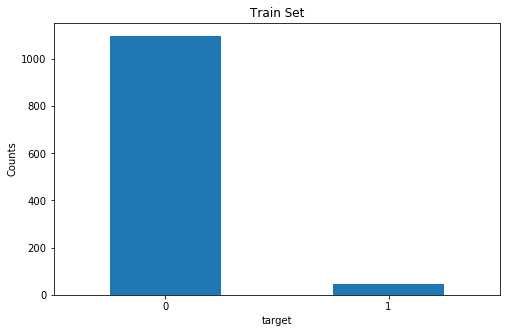

In [15]:
#plot the size of the classes
f, ax1 = plt.subplots(figsize=(8,5), sharey=True)
train_cts.plot(kind='bar',ax= ax1,rot=0)
ax1.set_title('Train Set')
ax1.set_ylabel("Counts")

#### Naive Bayes model (Grid-Search)

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
from sklearn.model_selection import GridSearchCV
param_grid = {'vect__ngram_range': [(1, 1), (1, 2), (1,3),(2,2)],
              'clf__alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0],
              'tfidf__use_idf': [True, False]}

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB(alpha=1))])

X = vacancies['body']
y = vacancies['target']
X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=20, stratify=y)

grid = GridSearchCV(text_clf, param_grid, cv=5)

grid.fit(X_train, y_train);

grid.best_params_

{'clf__alpha': 1e-06, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 1)}

In [19]:
predicted_best = grid.predict(X_test)
np.mean(predicted_best == y_test)

0.9563953488372093

##### Imbalanced metrics

In [20]:
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced
from imblearn.pipeline       import Pipeline 
from sklearn.model_selection import cross_validate
from imblearn.over_sampling  import RandomOverSampler
import numpy as np
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

In [22]:
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, predicted_best))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.96      1.00      0.00      0.98      0.00      0.00       330
          1       0.00      0.00      1.00      0.00      0.00      0.00        14

avg / total       0.92      0.96      0.04      0.94      0.00      0.00       344



In [23]:
from sklearn.metrics import balanced_accuracy_score

print("balanced_accuracy", balanced_accuracy_score(y_test, 
                                                   predicted_best))

balanced_accuracy 0.4984848484848485


In [24]:
from sklearn.metrics import f1_score

print("weighted f1 score:", f1_score(y_test, 
                                     predicted_best, 
                                     average="weighted"))

weighted f1 score: 0.9379211444763121


##### Using Oversampling for Imbalanced data

In [35]:
nb_pipe2  = Pipeline([('vect',    CountVectorizer()),
                     ('tfidf',   TfidfTransformer()),
                     ('sampler', RandomOverSampler('minority',random_state=42)),
                     ('model',   MultinomialNB(alpha=1))])

/Users/nalevizos/opt/anaconda3/lib/python3.9/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=minority as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [26]:
def evaluate_model(
    X_train : pd.DataFrame,
    y_train : pd.DataFrame,
    X_test  : pd.DataFrame,
    y_test  : pd.DataFrame,
    pipe    : Pipeline,
) -> None:

    model = pipe.fit(X_train, 
                     y_train)


    pred  = model.predict(X_test)

    print(classification_report(y_test,
                                pred))
    
    print()
    print("balanced_accuracy", balanced_accuracy_score(y_test, 
                                                       pred))

In [30]:
from functools import partial

X = vacancies['body']
y = vacancies['target']
X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=20, stratify=y)

evaluate_pipeline = partial(evaluate_model,
                            X_train,
                            y_train,
                            X_test,
                            y_test,)

In [36]:
evaluate_pipeline(nb_pipe2)

              precision    recall  f1-score   support

           0       0.98      0.86      0.92       330
           1       0.13      0.50      0.21        14

    accuracy                           0.85       344
   macro avg       0.56      0.68      0.56       344
weighted avg       0.94      0.85      0.89       344


balanced_accuracy 0.6818181818181819


#### Try for one random sample

In [48]:
imb_model = nb_pipe2.fit(X_train, 
                     y_train)

vacancy_sample = ['Ben jij student? Wil je wat bijverdienen naast je studie ? Kom dan bij ons werken en meld je aan. Maakt niet uit of je nog op school zit. Dit is voor een bijbaan na schooltijd. Je krijgt een normaal salaris']

pred  = imb_model.predict_proba(vacancy_sample)

In [52]:
pred

array([[0.29893562, 0.70106438]])